In [23]:
%load_ext autoreload
%autoreload 2

# DATA MANIPULATION
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

# DATA VISUALISATION
import matplotlib.pyplot as plt
import seaborn as sns

# VIEWING OPTIONS IN THE NOTEBOOK
from sklearn import set_config
#set_config(display='diagram')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
data = pd.read_csv('../data/data_for_model_legs.csv')
data['snow'] = data['snow'].replace(np.nan, 0)

data.head()
X = data[['trip', 'temp', 'prcp', 'wspd', 'wpgt', 'snow', 'coco', 'weekday', 'month', 'time_of_day']]
y = data['target_numeric']  

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2)

train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

# train is now 75% of the entire data set
# the _junk suffix means that we drop that variable completely
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio)

# test is now 10% of the initial data set
# validation is now 15% of the initial data set
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 


In [26]:
X_train

,trip,temp,prcp,wspd,wpgt,snow,coco,weekday,month,time_of_day
82682,Mannheim-Frankfurt,28.3,0.0,13.0,27.8,0.0,good,Sunday,July,afternoon
13870,Mannheim-Köln,3.0,0.0,10.4,18.0,0.0,good,Saturday,April,evening
1939,Frankfurt-Köln,10.8,0.0,11.2,18.0,0.0,medium,Friday,October,afternoon
16734,München-Köln,-0.1,0.0,7.6,11.0,0.0,good,Monday,January,evening
42817,Frankfurt-München,9.1,0.0,9.4,17.0,0.0,medium,Monday,September,evening
...,...,...,...,...,...,...,...,...,...,...
68959,Mannheim-München,-0.8,0.0,6.8,14.0,0.0,good,Tuesday,March,evening
30197,München-Köln,15.1,0.0,7.9,18.0,0.0,medium,Monday,September,morning
71164,Mannheim-München,18.5,0.0,14.0,31.0,0.0,medium,Friday,July,evening
37341,Würzburg-Köln,20.3,0.0,25.2,44.0,0.0,medium,Monday,June,afternoon


In [27]:
y.value_counts()

0      40887
1      10745
2       8906
3       6339
4       4600
       ...  
114        8
115        8
111        7
107        7
116        5
Name: target_numeric, Length: 121, dtype: int64

In [28]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectPercentile, mutual_info_regression
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer

def create_preproc_ordinal():
    feat_ordinal_dict = {
        # considers "missing" as the worse category
        "coco": ['good', 'medium', 'bad', 'extreme']
    }

    feat_ordinal = sorted(feat_ordinal_dict.keys())
    feat_ordinal_values_sorted = [feat_ordinal_dict[i] for i in feat_ordinal]

    encoder_ordinal = OrdinalEncoder(
        categories=feat_ordinal_values_sorted,
        handle_unknown="use_encoded_value",
        unknown_value=-1  # Considers unknown values as worse than "missing"
    )

    preproc_ordinal = make_pipeline(
        SimpleImputer(strategy="constant", fill_value="missing"),
        encoder_ordinal,
        MinMaxScaler()
    )

    return preproc_ordinal, feat_ordinal


def create_preproc_numerical():
    return make_pipeline(
        KNNImputer(),
        MinMaxScaler()
    )

def create_preproc_nominal():
    return make_pipeline(
        SimpleImputer(strategy="most_frequent"),
        OneHotEncoder(handle_unknown="ignore")
    )

In [29]:
def create_preproc(X, percentile = 75):
    """Create an (unfitted) sklearn preprocessing pipeline well suited for the Houses Kaggle Competition

    Args:
        X (pandas.DataFrame): Feature matrix
        percentile (float): Percentage of feature to keep after one hot encoding

    Returns:
        sklearn.pipeline.Pipeline: un-fitted preprocessor
    """
    preproc_ordinal, feat_ordinal = create_preproc_ordinal()
    
    preproc_numerical = create_preproc_numerical()
    feat_numerical = sorted(X.select_dtypes(
        include=["int64", "float64"]).columns)
    
    preproc_nominal = create_preproc_nominal()
    feat_nominal = sorted(
        list(set(X.columns) - set(feat_numerical) - set(feat_ordinal)))
    
    feature_transformer = ColumnTransformer(
        [
        ("numerical_encoder", preproc_numerical, feat_numerical),
        ("ordinal_encoder", preproc_ordinal, feat_ordinal),
        ("nominal_encoder", preproc_nominal, feat_nominal)
        ],
        remainder="drop")

    feature_selector = SelectPercentile(
        mutual_info_regression,
        percentile=percentile,  # keep the xx% most important features
    )

    preproc = make_pipeline(
        feature_transformer,
        #feature_selector #disabling it for now, mostly for debugging purposes
    )
    return preproc

In [30]:
preproc = create_preproc(X_train)
preproc

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numerical_encoder',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['prcp', 'snow', 'temp',
                                                   'wpgt', 'wspd']),
                                                 ('ordinal_encoder',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['good',
                                                                                               'medium',
                                                                                               'bad',
                                                                                               'extreme']],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1)),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['coco']),
                                                 ('nominal_encoder',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['month', 'time_of_day',
                                                   'trip', 'weekday'])]))])

In [31]:
# Fit the preprocessor on the train set
preproc.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numerical_encoder',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['prcp', 'snow', 'temp',
                                                   'wpgt', 'wspd']),
                                                 ('ordinal_encoder',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['good',
                                                                                               'medium',
                                                                                               'bad',
                                                                                               'extreme']],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1)),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['coco']),
                                                 ('nominal_encoder',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['month', 'time_of_day',
                                                   'trip', 'weekday'])]))])

In [32]:
# Create the preprocessed versions of X_train and X_val
X_train_preproc = preproc.transform(X_train)
X_val_preproc = preproc.transform(X_val)

# Let's also already create the preprocessed version of X_test for our future predictions
X_test_preproc = preproc.transform(X_test)

In [33]:
# Shapes before preprocessing
X_train.shape, X_val.shape #X_test.shape

((84634, 10), (16927, 10))

In [34]:
# Shapes after preprocessing
X_train_preproc.shape, X_val_preproc.shape #,X_test_preproc.shape

((84634, 49), (16927, 49))

# KNN REGRESSOR

In [ ]:
# Run a search with cross_validate to find the optimal
from sklearn.neighbors import KNeighborsRegressor

k_range = [180, 190, 200, 210, 220, 230, 240, 250] # Totally arbitrary, but previous testing suggests it's best to use at least 180

scores = []

# We append the scores in the dictionary
for k in k_range:
    neigh = KNeighborsRegressor(n_neighbors=k)
    cv_results = cross_validate(neigh, X_train_preproc, y_train, cv=5, 
                            scoring=['max_error',
                                     'r2', 
                                     'neg_mean_absolute_error',
                                     'neg_mean_squared_error']
                           )
    cv_results = pd.DataFrame(cv_results)
    scores.append(cv_results['test_r2'].mean())
       
plt.plot(k_range, scores, label = 'Training score')
#plt.plot(scores_, test_scores_mean, label = 'Test score')

In [180]:
# Use the optimal K and cross  validate more times to find a stable test result
from sklearn.neighbors import KNeighborsRegressor

neigh = KNeighborsRegressor(n_neighbors=200)

cv_results = cross_validate(neigh, X_train_preproc, y_train, cv=15, 
                            scoring=['max_error',
                                     'r2', 
                                     'neg_mean_absolute_error',
                                     'neg_mean_squared_error']
                           )
cv_results = pd.DataFrame(cv_results)
score = cv_results['test_r2'].mean()
score

0.011849267168280785

In [174]:
cv_results

,fit_time,score_time,test_max_error,test_r2,test_neg_mean_absolute_error,test_neg_mean_squared_error
0,0.007167,0.856559,-120.0,-0.356778,-18.347056,-1063.695734
1,0.009172,0.894309,-120.0,-0.345745,-17.872505,-1002.411302
2,0.006938,0.981503,-120.0,-0.372852,-17.111028,-933.304017
3,0.004471,0.897237,-120.0,-0.405196,-18.849301,-1107.093812
4,0.004414,0.750898,-120.0,-0.334492,-17.778443,-1049.307884
5,0.003303,0.592639,-120.0,-0.344676,-17.788922,-1004.054391
6,0.003719,0.592508,-120.0,-0.345293,-18.832585,-1118.199227
7,0.003502,0.577999,-120.0,-0.301239,-16.966567,-950.511228
8,0.003281,0.568158,-120.0,-0.321321,-17.701846,-1018.100424
9,0.003340,0.577582,-120.0,-0.364601,-18.031437,-1050.286926


# XGBoost

In [22]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_validate

xgb = GradientBoostingRegressor(max_depth=10, n_estimators=100, learning_rate=0.1)
#xgb = XGBRegressor(max_depth=5, n_estimators=60, learning_rate=0.5) ### standard from lecture
#xgb = XGBRegressor(learning_rate=0.05, max_depth = 1, n_estimators = 50) 
#(max_depth=10, n_estimators=100, learning_rate=0.1) 

cv_results = cross_validate(xgb, X_train_preproc, y_train, cv=15, 
                            scoring=['max_error',
                                     'r2', 
                                     'neg_mean_absolute_error',
                                     'neg_mean_squared_error'])

#xgb.fit(transformed,y)
cv_results = pd.DataFrame(cv_results)
score = cv_results['test_r2'].mean()
score

-0.060746482788637125

# CNN Regressor

In [194]:
from tensorflow.keras import Sequential, layers
from keras.layers import Dropout
from tensorflow import keras

def initialize_model(X):

    #################################
    #  1 - Model architecture       #
    #################################
    
    model = Sequential()
    
    # Input Layer
    model.add(layers.Dense(50, activation='relu', input_dim = X.shape[-1]))
    
    # Hidden Layers
    model.add(layers.Dense(30, activation='relu'))
    model.add(layers.Dense(15, activation='relu'))
    model.add(Dropout(0.1))
    model.add(layers.Dense(15, activation='relu'))
    model.add(Dropout(0.15))   
    model.add(layers.Dense(10, activation='relu'))
    model.add(Dropout(0.2))
    
    # Predictive Layer
    model.add(layers.Dense(1, activation='linear'))
    
    ##################################
    #  2 - Our recommended compiler  #
    ##################################
    #optm = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
    opt = keras.optimizers.Adam(learning_rate=0.0005)


    model.compile(optimizer=opt,
                  #loss='msle')      # directly optimize for the squared log error!
                  loss='mean_squared_error')
    
    return model

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
tf.config.run_functions_eagerly(True)

es = EarlyStopping(patience=5, restore_best_weights=True)

model = initialize_model(X_train_preproc)
model.summary()

# Training the model
epochs = 150
batch_size = 32

history = model.fit(X_train_preproc, 
                    y_train,
                    validation_data = (X_val_preproc, y_val),
                    epochs = epochs,         
                    batch_size = batch_size, 
                    callbacks=[es],
                    verbose = 1)

# 3. Evaluating the model
res = model.evaluate(X_val_preproc, y_val, verbose = 0)
print(f"RMLSE achieved after {epochs} epochs = {round(res**0.5,3)}")

# 4. Looking at the lowest loss
minimium_rmlse_val = min(history.history['val_loss'])**0.5
optimal_momentum = np.argmin(history.history['val_loss'])

print(f"Lowest RMLSE achieved = {round(minimium_rmlse_val,3)}")
print(f"This was achieved at the epoch number {optimal_momentum}") 

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_79 (Dense)            (None, 50)                1200      
                                                                 
 dense_80 (Dense)            (None, 30)                1530      
                                                                 
 dense_81 (Dense)            (None, 15)                465       
                                                                 
 dropout_30 (Dropout)        (None, 15)                0         
                                                                 
 dense_82 (Dense)            (None, 15)                240       
                                                                 
 dropout_31 (Dropout)        (None, 15)                0         
                                                                 
 dense_83 (Dense)            (None, 10)              

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


940/940 [==============================] - 19s 20ms/step - loss: 798.8979 - val_loss: 802.1256
Epoch 2/150
940/940 [==============================] - 17s 18ms/step - loss: 774.8044 - val_loss: 799.2811
Epoch 3/150
940/940 [==============================] - 18s 19ms/step - loss: 769.5433 - val_loss: 801.8110
Epoch 4/150
940/940 [==============================] - 19s 20ms/step - loss: 769.1176 - val_loss: 797.8961
Epoch 5/150
940/940 [==============================] - 19s 20ms/step - loss: 767.3867 - val_loss: 795.4204
Epoch 6/150
940/940 [==============================] - 19s 20ms/step - loss: 766.2794 - val_loss: 794.1146
Epoch 7/150
940/940 [==============================] - 17s 18ms/step - loss: 766.0490 - val_loss: 794.9700
Epoch 8/150
940/940 [==============================] - 19s 20ms/step - loss: 764.8331 - val_loss: 800.6851
Epoch 9/150
940/940 [==============================] - 17s 19ms/step - loss: 762.5292 - val_loss: 792.2918
Epoch 10/150
940/940 [===========================

In [189]:
y_train

38861    18
20935     1
16228     0
33441     0
33173     0
         ..
19106    21
12882     0
10488     3
21925     0
26760     0
Name: target_numeric, Length: 30059, dtype: int64

# SCORING

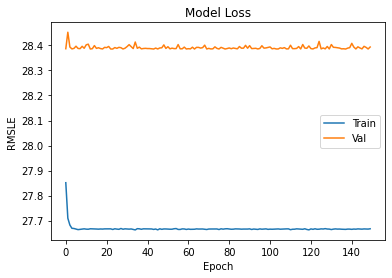

In [184]:
def plot_history(history):
    plt.plot(np.sqrt(history.history['loss']))
    plt.plot(np.sqrt(history.history['val_loss']))
    plt.title('Model Loss')
    plt.ylabel('RMSLE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='best')
    plt.show()
  
plot_history(history)

# PREDICTION

In [ ]:
X_test_preproc = preproc.transform(X_test)
predictions = model.predict(X_test_preproc)

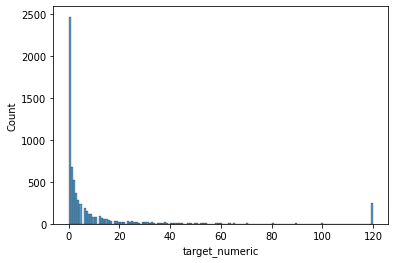

In [ ]:
sns.histplot(y_train)

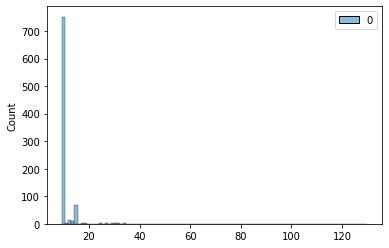

In [ ]:
sns.histplot(predictions,bins=100)

In [ ]:
#calculate error of test (unfinished)
errordf = pd.DataFrame(predictions, np.array(y_test)).reset_index()
errordf.columns = ['actual','predicted']
np.log(np.exp(errordf['predicted'] - errordf['actual'])).mean()




-0.1388238702116713

# SAVING

In [ ]:
from sklearn.pipeline import Pipeline
import joblib

model_name = model

pipeline = Pipeline([
      ('pipeline', create_preproc(X_train)),
      ('model', model_name)
    ])
pipeline.fit(X_train, y_train)

joblib.dump(pipeline, 'model.joblib')

In [ ]:
# This is for loading an existing model

model_api = joblib.load('model.joblib')
print(model_api.predict(X_test)) # X_test here is in the same format as preprocessed data, pipeline is included in the model
print(model_api.predict_proba(X_test))